# Making a Five Animal Classifier and Deploying It

## Install and Import Required Libraries

In [ ]:
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade
!pip install -Uqq azure-cognitiveservices-search-imagesearch
!pip install -Uqq anvil-uplink

import fastai
import fastcore
from fastai.vision.all import *
from fastai.vision.widgets import *
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

     |████████████████████████████████| 189 kB 12.3 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 


## Connect to Google Drive

- Make sure it's within a contained folder for the project.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/LETU/'

/content/drive/MyDrive/LETU


## Acquiring images

- Bing Search Engine API code below. Use infrequently as it has usage limits.

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '161433e0da0b4f168658a54201b384e9')

- Function to search (no modification required)

In [ ]:
def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

- Set the search keys into a variable as well as a path for them to be downloaded in.

In [ ]:
food_types = 'russian potato salad','olivier salad', "niislel salad", "khuushuur", "buuz", "tsuivan"
path = Path('foods')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in food_types:
        print(f'Finding images for {o}')
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

Finding images for russian potato salad
Finding images for olivier salad


In [ ]:
fns = get_image_files(path)
fns

(#649) [Path('foods/khuushuur/00000000.jpg'),Path('foods/khuushuur/00000005.jpg'),Path('foods/khuushuur/00000006.jpg'),Path('foods/khuushuur/00000004.jpg'),Path('foods/khuushuur/00000001.jpg'),Path('foods/khuushuur/00000003.jpg'),Path('foods/khuushuur/00000009.jpg'),Path('foods/khuushuur/00000008.jpg'),Path('foods/khuushuur/00000011.jpg'),Path('foods/khuushuur/00000007.png')...]

- Unlink failed images.

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink)

(#0) []

## Modeling data

In [ ]:
foods = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    get_y=parent_label,
                    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                    batch_tfms=aug_transforms())

In [ ]:
dls = foods.dataloaders(path)

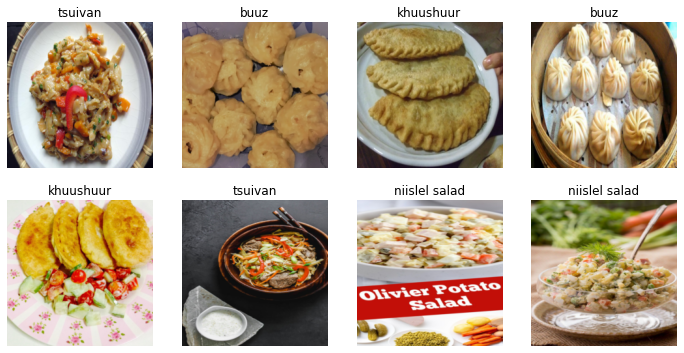

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

## Perform Transfer Learning

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

### Evaluate Learner

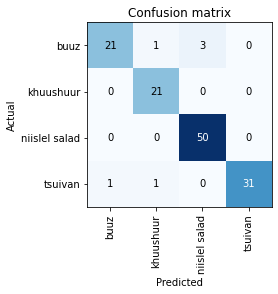

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

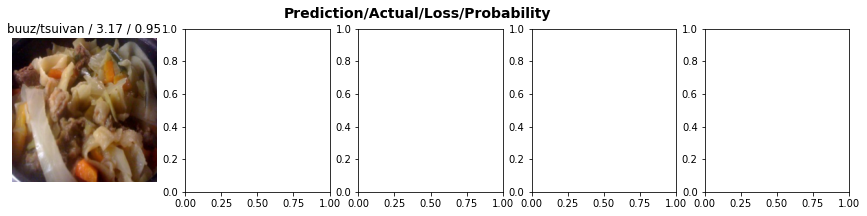

In [ ]:
interp.plot_top_losses(5, nrows=1)

## Scrub Images

Very slow to work with, better done manually (which I have).

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Train Again

In [ ]:
foods = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    get_y=parent_label,
                    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                    batch_tfms=aug_transforms())

In [ ]:
dls = foods.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(14)

Plateaued around 2%.

### Evaluate Learner

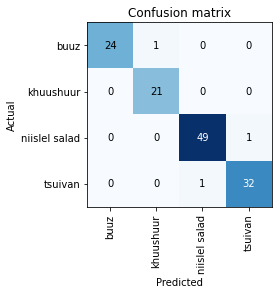

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Works very well with potato salads now because potato salad is the only item that has multiple names.

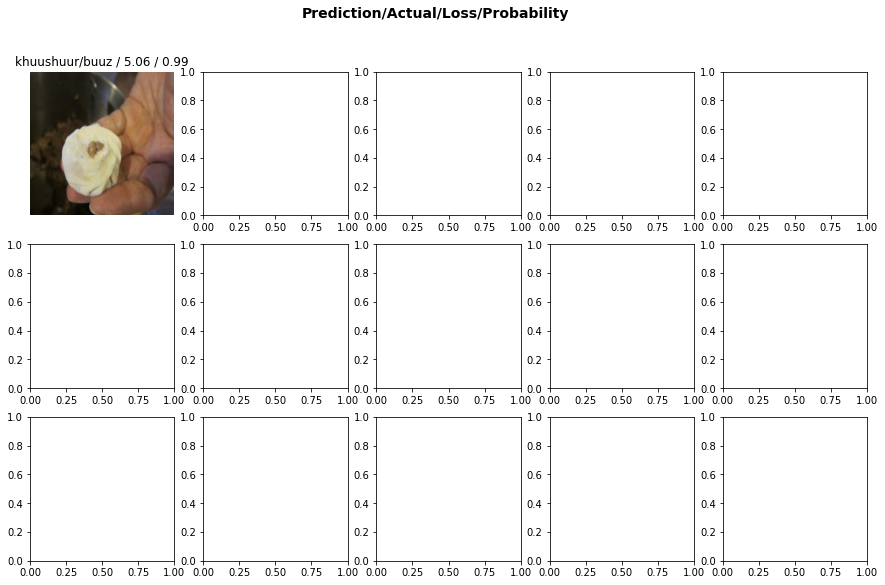

In [ ]:
interp.plot_top_losses(15, nrows=3)

## Export Model

Once you are happy with your model you can export it. The 

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Anvil Function

I've done an Anvil app and a streamlit app.

In [ ]:
from fastai.vision.all import *

In [ ]:
learn_inf = load_learner('export.pkl')

In [ ]:
import anvil.server
import anvil.media

anvil.server.connect("server_66FZOYY726Q3WQU4SI65PPIU-ZNWMJ32CZOUWLC25")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [ ]:
@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as f:
        img = PILImage.create(f)
    
    pred, pred_idx, probs = learn_inf.predict(img)

    return pred, max(probs.tolist())